# Início

In [ ]:
print("hello world")

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from numpy.testing import assert_allclose
from keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

2024-10-30 16:33:45.940495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 16:33:46.320027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-30 16:33:47.032263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 16:33:47.056451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 16:33:47.058932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Definindo diretório de imagens
Definindo o diretório que contém as pastas contendo as imagens categorizada.

In [3]:
# Mapear arquivos ocultos (.ipny)
# A ser utilizada caso não tenha o .ipynb_checkpoints
def filter_hidden_folders(folder_list):
    return [folder for folder in folder_list if not folder.startswith('.')]

In [4]:
# Caminho para os dados do dataset e o reescalador de imagens
xray_directory = 'font_results/normal'

xray_classes = os.listdir(xray_directory)
print(f"Classes: {xray_classes}")

class_count = len(os.listdir(xray_directory))
print(f"Quantidade de classes:{class_count} => 26 letras maiúsculas + 26 minúsculas + 1 nula")

Classes: ['g', 'V', 'W', 'r', 'i', 'a', 'G', 'I', 's', 'J', 'y', 'z', 't', 'c', 'Q', 'u', 'E', 'o', 'H', 'B', 'U', 'N', 'F', 'm', 'n', 'v', 'T', 'D', 'A', 'e', 'w', 'O', '.ipynb_checkpoints', 'S', 'K', 'l', 'C', 'q', 'p', 'Z', 'j', 'h', 'f', 'L', 'M', 'b', 'd', 'P', 'x', 'X', 'Y', 'R', 'k']
Quantidade de classes:53 => 26 letras maiúsculas + 26 minúsculas + 1 nula


## Criando a rede neural

In [5]:
# Definir parâmetros
INPUT_SHAPE = (100, 180, 1)  # Imagem 180x100, 1 canal (grayscale)

In [6]:
# Carregar o modelo VGG16 pré-treinado com pesos do ImageNet
# Incluir a camada de pooling global (retirar as camadas de classificação final)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 180, 3))

# Adaptar a camada de entrada para grayscale (1 canal)
# Expanda o canal para 3 (de 1 para 3) para o modelo pré-treinado que usa RGB
inputs = layers.Input(shape=INPUT_SHAPE)
model_flow = layers.Conv2D(3, (3, 3), padding='same')(inputs)  # Converter 1 canal para 3

# Conectar o modelo pré-treinado
model_flow = base_model(model_flow)
model_flow = layers.GlobalAveragePooling2D()(model_flow)

# Adicionar as camadas de classificação
model_flow = layers.Dense(512, activation='relu')(model_flow)
model_flow = layers.Dense(class_count, activation='softmax')(model_flow)

# Criar o modelo final
model = models.Model(inputs, model_flow)

# Congelar as camadas do modelo pré-treinado para não treiná-las no início
for layer in base_model.layers:
    layer.trainable = False

2024-10-30 16:33:48.236950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 16:33:48.239462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 16:33:48.241507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 180, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 180, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 3, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,004,563 (57.24 MB)

 Trainable params: 289,875 (1.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Salvar o arquivo de treinamento em diferentes epocas

# Nome/caminho do arquivo que sera salvo
model_file = "weights_normal_vgg16.keras" 

# Define os parametros para atualizar o arquivo final
# ModelCheckpoint(nome_do_arquivo, monitor = 'parametro a ser analisado', verbose = 1 (imprimir no console quando arquivo for salvo), save_best_only = True, mode = 'min' (objetivo minimizar perda))
checkpoint = ModelCheckpoint(model_file, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

# Cria uma lista que contém o ModelCheckpoint configurado usado durante o treinamento
callbacks_list = [checkpoint]

## Criando as bases de dados

In [9]:
# Gerenciador de imagem para pre processamento
# Normaliza(rescale) a base de dados
# Divide a base de dados para que parte dela seja usada na validação dos dados. 
# Aumenta a base através de leves alterações como: zoom aleatório <= zoom_range
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.3,
    zoom_range=0.2,
    )


In [10]:
BATCH_SIZE = 50
TARGET_SIZE=(100, 180) # ALTURA X LARGURA, é invertido aqui...
CMODE='grayscale'
CLASS_MODE='categorical'
# Imagens para treinamento
train_generator = train_datagen.flow_from_directory(
    xray_directory,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=CMODE, 
    class_mode=CLASS_MODE,
    shuffle=True,
    subset='training'
)

# Imagens para validação
validation_generator = train_datagen.flow_from_directory(
        xray_directory,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode=CMODE,
        class_mode=CLASS_MODE,
        shuffle=True,
        subset = 'validation'
        )


Found 2658448 images belonging to 53 classes.
Found 1139268 images belonging to 53 classes.


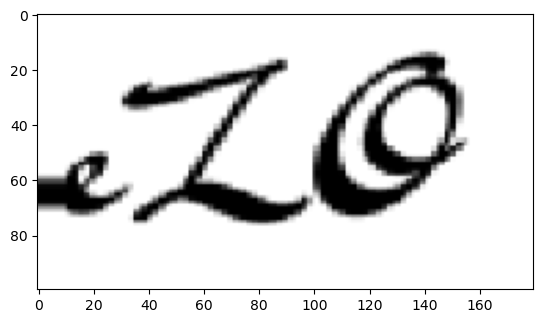

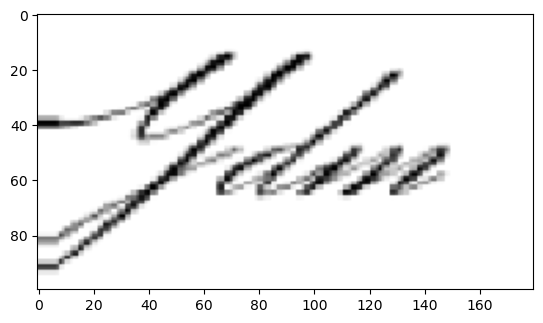

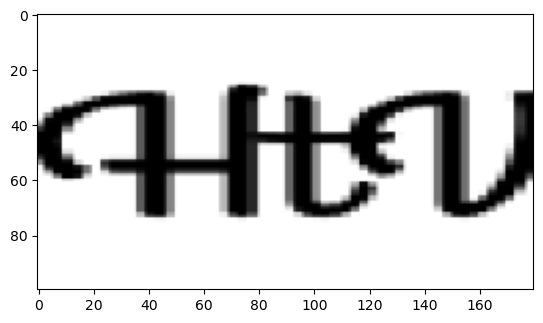

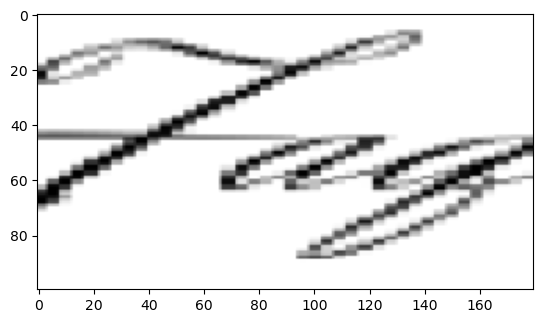

In [11]:
#Visualizando amostra da base de dados de treinamento.
def show_images_in_range(images, RANGE = 2):
    for i in range(0, RANGE):  # Mostra as primeiras 5 imagens
        image = images[i]
        plt.imshow(image, cmap = "gray")
        plt.show()


train_batch, _ = next(train_generator)
show_images_in_range(train_batch)
val_batch, _ = next(validation_generator)
show_images_in_range(val_batch)


In [12]:
# Visualizando formato das imagens no banco e classes
print(train_generator.class_indices)

for data_batch, labels_batch in train_generator:
    print("Imagens: ", data_batch.shape)
    print("Labels: ", labels_batch.shape)
    break  # Apenas testar um batch


{'.ipynb_checkpoints': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52}
Imagens:  (50, 100, 180, 1)
Labels:  (50, 53)


## treinamento do modelo 

steps_per_epoch = len(train_generator) - 1  # Total de batches por época

In [ ]:
# load the model
saved_model = load_model(model_file)

In [ ]:
# só por garantia tá fazendo coisa q já fez
#checkpoint = ModelCheckpoint(model_file, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
#callbacks_list = [checkpoint]



In [ ]:
import json
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

class CustomCallback(Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        self.logs_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        # Salva os logs de cada época na lista
        self.logs_per_epoch.append({'epoch': epoch, 'logs': logs})
        
        # Salva os logs no arquivo JSON a cada época
        with open("log_normal_vgg16.json", "w") as f:
            json.dump(self.logs_per_epoch, f, indent=4)

        # Exibe os logs da época no console
        print(f"Epoch {epoch}: {logs}")

# Configura o checkpoint do modelo
checkpoint = ModelCheckpoint(model_file, monitor='loss', verbose=1, save_best_only=True, mode='min')

# Adiciona o callback personalizado e o checkpoint na lista de callbacks
custom_callback = CustomCallback()
callbacks_list = [checkpoint, custom_callback]

# Treinamento do modelo
history = model.fit(
    train_generator,
    epochs=20,  # Ajuste o número de épocas conforme necessário
    validation_data=validation_generator,
    callbacks=callbacks_list
)


Epoch 1/20


/home/picg/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730316880.465141  165976 service.cc:145] XLA service 0x766d200048b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730316880.465170  165976 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-10-30 16:34:40.481529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 16:34:40.575722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1730

    3/53169 ━━━━━━━━━━━━━━━━━━━━ 55:01 62ms/step - accuracy: 0.0478 - loss: 4.0471

I0000 00:00:1730316888.232728  165976 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51223/53169 ━━━━━━━━━━━━━━━━━━━━ 1:58 61ms/step - accuracy: 0.4210 - loss: 2.1096

I0000 00:00:1730319994.746331  166984 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_868', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730319994.888750  166980 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1084', 428 bytes spill stores, 428 bytes spill loads

I0000 00:00:1730319995.244964  166997 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1084', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1730319995.312804  166986 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1075', 212 bytes spill stores, 212 bytes spill loads



53169/53169 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4250 - loss: 2.0933

In [ ]:
# rodando o novo modelo por mais 11 épocas pq era oq faltava
history = saved_model.fit(train_generator, epochs = 11, validation_data=validation_generator, callbacks=callbacks_list)
aux = history
history = history.history.keys() #paramestros de avaliação accuracy, loss

In [ ]:
history = model.fit(train_generator, epochs = 25, validation_data=validation_generator, callbacks=callbacks_list)
aux = history
history = history.history.keys() #paramestros de avaliação accuracy, loss

## Salvando progresso

In [ ]:
hist_df = pd.DataFrame(aux.history)
print(hist_df)

In [ ]:
# Salvar o DataFrame em um arquivo CSV
hist_df.to_csv('training_history_normal_vgg16.csv', index=False)

In [14]:
# Carregar os dados do CSV
loaded_history_df = pd.read_csv('training_history_normal_vgg16.csv')
# Exibir os dados carregados (opcional)
print(loaded_history_df)

    epoch  accuracy      loss  val_accuracy  val_loss
0       0  0.530323  1.657153      0.425015  2.213207
1       1  0.659532  1.152669      0.465649  2.096441
2       2  0.690940  1.038554      0.469895  2.146371
3       3  0.708069  0.979439      0.481787  2.105935
4       4  0.717970  0.943256      0.478822  2.183059
5       5  0.726004  0.916331      0.493510  2.060065
6       6  0.732153  0.894516      0.485454  2.161517
7       7  0.736601  0.879373      0.495829  2.153138
8       8  0.739916  0.866433      0.486468  2.245849
9       9  0.743357  0.855009      0.500807  2.149192
10     10  0.745667  0.846159      0.499669  2.134469
11     11  0.748268  0.837193      0.484641  2.256290
12     12  0.750762  0.829683      0.494291  2.166248
13     13  0.752372  0.823187      0.508365  2.125515
14     14  0.754076  0.817650      0.506615  2.155431
15     15  0.755543  0.812265      0.507884  2.137885
16     16  0.756969  0.807294      0.501490  2.205667
17     17  0.758108  0.80381

## Visualização do progresso do modelo

### Visualização: Linhas de erro, loss, accuracy

In [ ]:
# Exemplo de grafico para ver taxa de acerto por taxa de erro 
plt.plot(loaded_history_df['accuracy'])
plt.plot(loaded_history_df['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);
plt.show()

In [ ]:
# Plotar a perda de treinamento e validação
plt.plot(loaded_history_df['loss'], label='Loss (train)')
plt.plot(loaded_history_df['val_loss'], label='Loss (validation)')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [ ]:

# Plotar a precisão de treinamento e validação
plt.plot(loaded_history_df['accuracy'], label='Accuracy (train)')
plt.plot(loaded_history_df['val_accuracy'], label='Accuracy (validation)')
plt.title('Precisão durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.show()

### Definindo funções de visualização

In [ ]:
#Comparação de Loss e Accuracy de redes distintas
def plot_comparison(results, metric='accuracy'):
    models = list(results.keys())
    final_accuracy = [results[model][metric][-1] for model in models]
    
    plt.figure(figsize=(10, 5))
    plt.bar(models, final_accuracy)
    plt.title(f'Comparação de {metric} entre diferentes redes')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Modelos')
    plt.show()

In [ ]:
#Grafico de curvas para comparação entre redes
def plot_comparison_curves(results, metric='accuracy'):
    plt.figure(figsize=(10, 5))
    
    for model, history in results.items():
        plt.plot(history[metric], label=f'{model} - train')
        plt.plot(history['val_' + metric], '--', label=f'{model} - val')
    
    plt.title(f'Comparação de {metric.capitalize()} entre Redes')
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


In [ ]:
#Matriz Confusão

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

In [ ]:
#Boxplot
def plot_boxplot(results, metric='accuracy'):
    data = [history[metric] for history in results.values()]
    labels = results.keys()

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title(f'Boxplot de {metric.capitalize()} entre Redes')
    plt.ylabel(metric.capitalize())
    plt.show()

### Funções auxiliares e variáveis

In [ ]:
def dataframe_to_dict(dataframe):
    return {
        'accuracy': dataframe['accuracy'].tolist(),
        'loss': dataframe['loss'].tolist()
    }

In [ ]:
history1 = pd.read_csv('training_history_normal_vgg16.csv')
history2 = pd.read_csv('training_history_normal_original.csv')
history_dict = {
    'normal VGG16': dataframe_to_dict(history1),
    'normal Original': dataframe_to_dict(history2),
}

## Chamando as funções de visualização

In [ ]:
plot_comparison(history_dict, metric='accuracy')

In [ ]:
plot_comparison(history_dict, metric='loss')

In [ ]:
# define caminho para pasta de teste
test_directory = 'dataset/test'
# lista contendo os nomes dos arquivos e diretórios presentes no caminho fornecido
os.listdir(test_directory)

In [ ]:
# Mudar a escala das imagens
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(batch_size = 13, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

evaluate = model.evaluate(test_generator)

len(os.listdir(test_directory))

In [ ]:
# aplica a rede treinada em um conjunto de teste de imagens e armazena os resultados
prediction = []
original = []
image = []

# percorre as subpastas no diretório test_directory, assumindo que cada subpasta contém imagens de uma determinada classe
for i in range(len(os.listdir(test_directory))):
  # percorre os arquivos dentro de cada subpasta e processa cada imagem
  for item in os.listdir(os.path.join(test_directory, str(i))):
    
    #Etapas de processamento de img

    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)

    #rede neural aplicada
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
accuracy_score(original, prediction)

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [ ]:
model_load = load_model('weights_normal_vgg16.keras')
image = Image.open("/home/picg/TCC/GeradorBase/font_results/normal/a/a-lal-GrandHotel-Regular.png")
image_grayscale = image.convert('L')
image_array = np.array(image_grayscale)
image_input_resized = cv2.resize(image_array, (100, 180))
print(image_input_resized.shape)
image_array_normalized = image_input_resized / 255.0

# Adicionar uma dimensão para corresponder ao formato de entrada esperado pelo modelo
final_image = image_array_normalized.reshape(1, 100, 180, 1)  # '1' aqui é o batch size

prediction = model_load.predict(final_image)
print("Predição:", prediction)


In [ ]:
plt.imshow(image_grayscale, cmap="gray")

In [ ]:
#image = np.array(Image.open("/home/picg/TCC/GeradorBase/font_results/normal/a/a-mam-GrandHotel-Regular.png"))
plt.imshow(image, cmap="gray")

In [ ]:

# Achar a classe com maior probabilidade
predicted_class = np.argmax(prediction)

# Definir labels (saidas) 
labels_names = {0: '.ipynb_checkpoints', 1: 'a',2: 'A',3: 'b',4: 'B',5: 'c',6: 'C',7: 'd',8: 'D',9: 'e',10: 'E', 11: 'f',12: 'F',13: 'g',14: 'G',15: 'h',16: 'H',17: 'i',18: 'I',19: 'j',20: 'J', 21: 'k',22: 'K',23: 'l',24: 'L',25: 'm',26: 'M',27: 'n',28: 'N',29: 'o',30: 'O', 31: 'p',32: 'P',33: 'q',34: 'Q',35: 'r',36: 'R',37: 's',38: 'S',39: 't',40: 'T', 41: 'u',42: 'U',43: 'v',44: 'V',45: 'w',46: 'W',47: 'x',48: 'X',49: 'y',50: 'Y', 51: 'z',52: 'Z',
                }

print(f"A classe prevista é - {predicted_class}: {labels_names[predicted_class]}")


In [ ]:
model_load.summary()

#### Todas as classes:
'''
{'.ipynb_checkpoints': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52}
'''
